In [1]:
!pip install /kaggle/input/efficientnet-keras-source-code/ -q --no-deps

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# Imports

In [2]:
import numpy as np
import pandas as pd

## Keras and Tf ##

import tensorflow as tf
import tensorflow.keras.callbacks as C
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras.optimizers as O
import tensorflow.keras.utils as U
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Utils

import random
import os
import math
import tqdm
import gc
gc.collect()


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_addons as tfa
import sys
sys.path.append('../input/iterative-stratification/iterative-stratification-master')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [3]:
FILE_PATH = "../input/ranzcr-clip-catheter-line-classification"

In [4]:
train = pd.read_csv(FILE_PATH + '/train.csv')

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30083 entries, 0 to 30082
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   StudyInstanceUID            30083 non-null  object
 1   ETT - Abnormal              30083 non-null  int64 
 2   ETT - Borderline            30083 non-null  int64 
 3   ETT - Normal                30083 non-null  int64 
 4   NGT - Abnormal              30083 non-null  int64 
 5   NGT - Borderline            30083 non-null  int64 
 6   NGT - Incompletely Imaged   30083 non-null  int64 
 7   NGT - Normal                30083 non-null  int64 
 8   CVC - Abnormal              30083 non-null  int64 
 9   CVC - Borderline            30083 non-null  int64 
 10  CVC - Normal                30083 non-null  int64 
 11  Swan Ganz Catheter Present  30083 non-null  int64 
 12  PatientID                   30083 non-null  object
dtypes: int64(11), object(2)
memory usage: 3.0+ MB


In [6]:
target_cols = [ 'ETT - Abnormal', 'ETT - Borderline',
       'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline',
       'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal',
       'CVC - Borderline', 'CVC - Normal', 'Swan Ganz Catheter Present']

# Folds

In [7]:
train['kfold'] = -1
train_targets = train[target_cols].values
kf = MultilabelStratifiedKFold(n_splits=5,random_state = 2020,shuffle = True)
for fold, (tr, te) in enumerate(kf.split(train, train_targets)):
    train.loc[te,'kfold'] = fold

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=2020 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [8]:
train_filepaths = (train['StudyInstanceUID'] + '.jpg').to_list()
train["StudyInstanceUIDFilePaths"] = train_filepaths

# Images

In [9]:
img_path = FILE_PATH + '/train'

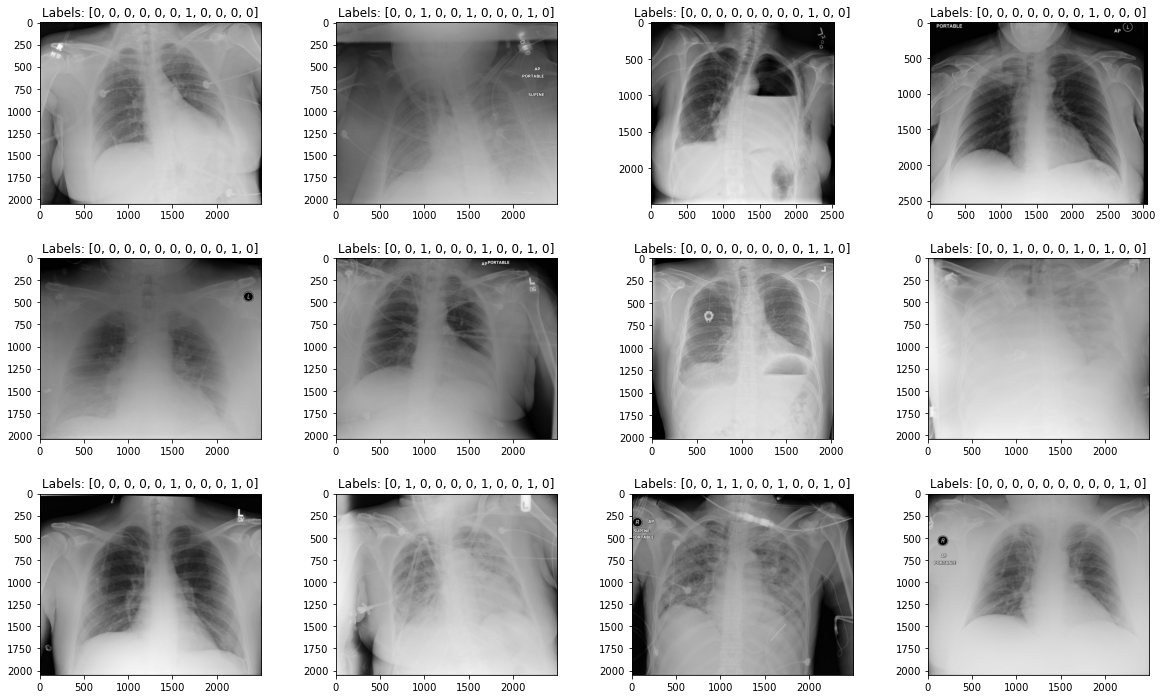

In [10]:
import matplotlib.image as immg
fig = plt.figure(1,figsize=(20,12))
columns = 4
rows = 3
fea_num = 0
fea_cols = target_cols
for i in range(rows*columns):
    fig.add_subplot(rows, columns, i+1)
    img = immg.imread(img_path+'/'+train_filepaths[i])
    plt.imshow(img,cmap='gray')
    plt.title(f'Labels: {train.iloc[i][target_cols].to_list()}')
    fea_num+=1
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

# Training

## Eff B2

In [11]:
train_df = train[train.kfold!=1]
valid_df = train[train.kfold==1]

In [12]:
IMAGE_SHAPE = (300, 300)
BATCH_SIZE = 32
TRAIN_PATHS = '../input/ranzor-clip-resized-data-512-256/trainXray_512'
LABELS = target_cols

train_datagen = ImageDataGenerator(rescale=1./255,
                                shear_range=0,
                                zoom_range=(1, 1.3),
                                rotation_range = 35,
                                width_shift_range=0.05, 
                                height_shift_range=0.05,
                                brightness_range = (0.8, 1.2),                                                   
                                horizontal_flip=True,
                                validation_split=0.2)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,x_col='StudyInstanceUIDFilePaths', y_col=LABELS,
    directory=TRAIN_PATHS, target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,class_mode='raw', subset='training') 

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=valid_df,x_col='StudyInstanceUIDFilePaths', y_col=LABELS,
    directory=TRAIN_PATHS, target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE, class_mode='raw', subset='validation')

Found 19256 validated image filenames.
Found 1202 validated image filenames.


In [13]:
base_model = tf.keras.applications.EfficientNetB2(weights='imagenet',include_top=False,input_shape=(300, 300, 3))
model = M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D())
model.add(L.Dropout(0.4))
model.add(L.Dense(1024, activation='swish'))
model.add(L.Dropout(0.3))
model.add(L.Dense(len(target_cols), activation='sigmoid'))

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['AUC'])
print(model.summary())

31793152/31790344 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 10, 10, 1408)      7768569   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1442816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                11275     
Total params: 9,222,660
Trainable params: 9,155,085
Non-t

In [14]:
checkpoint_path = "effb2"
cb_checkpt = C.ModelCheckpoint(checkpoint_path, monitor = 'val_auc', verbose = 2, save_best_only = True, save_weights_only = True, mode = 'max')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_auc',
                                                    mode = 'max',
                                                    factor = 0.3,
                                                    patience = 2,                                                     
                                                    verbose = 3)
early = tf.keras.callbacks.EarlyStopping(monitor = 'val_auc',
                                            mode = 'max',
                                            patience = 2,
                                            restore_best_weights = True,
                                            verbose = 3)

In [15]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // BATCH_SIZE,
    epochs = 10, callbacks = [cb_checkpt, reduce_lr, early], verbose=1)

Epoch 1/10
601/601 [==============================] - ETA: 0s - loss: 0.2424 - auc: 0.9207
Epoch 00001: val_auc improved from -inf to 0.77744, saving model to effb2
601/601 [==============================] - 861s 1s/step - loss: 0.2424 - auc: 0.9207 - val_loss: 0.3825 - val_auc: 0.7774
Epoch 2/10
601/601 [==============================] - ETA: 0s - loss: 0.2164 - auc: 0.9384
Epoch 00002: val_auc did not improve from 0.77744
601/601 [==============================] - 713s 1s/step - loss: 0.2164 - auc: 0.9384 - val_loss: 0.4224 - val_auc: 0.7238
Epoch 3/10
601/601 [==============================] - ETA: 0s - loss: 0.2084 - auc: 0.9435
Epoch 00003: val_auc improved from 0.77744 to 0.81735, saving model to effb2
601/601 [==============================] - 713s 1s/step - loss: 0.2084 - auc: 0.9435 - val_loss: 0.3739 - val_auc: 0.8174
Epoch 4/10
601/601 [==============================] - ETA: 0s - loss: 0.2014 - auc: 0.9478
Epoch 00004: val_auc did not improve from 0.81735
601/601 [==========